This notebook will give you a short demonstration of an OSEM reconstruction with multiple motion states. \
\
There are a number of papers out there that describe this, but I'll try and give you a little bit of the maths here as well

In [21]:
import sirf.STIR as stir
import sirf.Reg as reg
import numpy as np
import os
import sys
# add the source directory to the path
# This is to make everything nice and self-contained
dir_path = os.path.dirname(os.getcwd())
source_path = os.path.join(dir_path, 'source')
sys.path.append(source_path)

from reconstruction.reconstruction import *
from reconstruction.registration import *
from reconstruction.osem import *
from plotting_functions import plot_2d_image

# and some additional functions for plotting
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import imageio
from plotting_functions import *
from IPython.display import Image

Firstly, we'll create some sample data. In a more clinical setting, we wouldn't need to do this. Instead, we'd start with some PET data in the form of a sinogram and some reconstructed CT images in various motion states. These would then be converted to PET attenuation units (pobably using something called a bilinear model, but don't worry about that) \
\
We'll insted use an emission image phantom (a ground truth), an attenuation image phantom and a template sinogram containing our scanner geometry. We'll use these to create attenuation images and simulated data in various motion states

In [22]:
# First, let's get some template data
data_path = os.path.join(dir_path, 'data', 'template_data')
emission_image = stir.ImageData(os.path.join(data_path, 'emission.hv'))
attenuation_image = stir.ImageData(os.path.join(data_path, 'attenuation.hv'))
template_sinogram = stir.AcquisitionData(os.path.join(data_path, 'template_sinogram.hs'))


INFO: Setting energy window keys as in STIR3.0












Scanner parameters:= 
Scanner type := userdefined
Number of rings                          := 2
Number of detectors per ring             := 512
Inner ring diameter (cm)                 := 102
Average depth of interaction (cm)        := 0.7
Distance between rings (cm)              := 1.35
Default bin size (cm)                    := 0.3129
View offset (degrees)                    := 0
Maximum number of non-arc-corrected bins := 192
Default number of arc-corrected bins     := 192
Number of blocks per bucket in transaxial direction         := 1
Number of blocks per bucket in axial direction              := 1
Number of crystals per block in axial direction             := 1
Number of crystals per block in transaxial direction        := 8
Number of detector layers                                   := 1
Number of crystals per singles unit in axial direction      := 1
Number of crystals per singles unit in transaxial direction := 8
Scanner geometry (BlocksOnCylindrical/Cylindrical/Gen


INFO: Detected view-mashing factor 4 from the number of views (64) and the number of detectors per ring (512).
Adjusting the azimuthal angle offset accordingly (an extra offset of 1.05469 degrees)


0.08260853


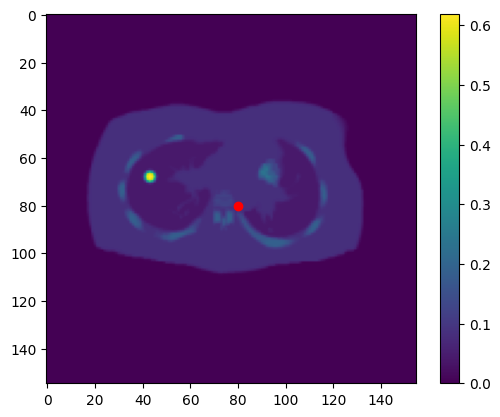

In [23]:
emission_image/=100 # I'm not sure why this is necessary, but it is to get the attenuation image in reasonable units
plt.imshow(emission_image.as_array()[0, :, :])
plt.colorbar()
# add point on image at 80, 80
plt.scatter(80, 80, c='r')
# print the value at 80, 80
print(emission_image.as_array()[0, 80, 80])

In [24]:
# Let's say that we have 10 different motion state bins
num_motion_states = 10

In [25]:
# we'll use some helper functions to generate the motion states
motion_emissions, motion_attenuations = [transformed_images for transformed_images in zip(*[generate_transformed_image(emission_image, attenuation_image) for i in range(num_motion_states)])]

# and then use Nifty Reg to estimate the transformations
# It would be really good if we could do this step using a neural network - Have a look at something called Voxelmorph fgor inspiration
motion_transforms = [find_transformation_matrix(transformed_image, attenuation_image) for transformed_image in motion_attenuations]



Starting registration...

[reg_aladin_sym] Parameters
[reg_aladin_sym] Platform: cpu_platform
[reg_aladin_sym] Reference image name: (null)
[reg_aladin_sym] 	155x155x1 voxels
[reg_aladin_sym] 	3.129x3.129x6.75 mm
[reg_aladin_sym] Floating image name: (null)
[reg_aladin_sym] 	155x155x1 voxels
[reg_aladin_sym] 	3.129x3.129x6.75 mm
[reg_aladin_sym] Maximum iteration number: 10
[reg_aladin_sym] 	(20 during the first level)
[reg_aladin_sym] Percentage of blocks: 50 %
[reg_aladin_sym] * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
[reg_aladin_sym] Current level 1 / 3
[reg_aladin_sym] reference image size: 	39x39x1 voxels	12.516x12.516x6.75 mm
[reg_aladin_sym] floating image size: 	39x39x1 voxels	12.516x12.516x6.75 mm
[reg_aladin_sym] Block size = [4 4 1]
[reg_aladin_sym] * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
[reg_aladin_sym] Forward Block number = [10 10 1]
[reg_aladin_sym] Backward Block number = [10 10 1]
[reg_aladin_sym] Initial forward transformation 

In [26]:
# let's check that these transformation matrixes are sensible

untransformed_images = [] # crap name, I know. These are the images that have been transformed back to the reference frame using the inverse of the transformation matrices we just estimated
for i in range(num_motion_states):
    resampler = reg.NiftyResample()
    resampler.set_reference_image(emission_image)
    resampler.set_floating_image(motion_emissions[i])
    resampler.set_interpolation_type_to_linear()
    resampler.add_transformation(motion_transforms[i].get_inverse())
    resampler.process()
    untransformed_images.append(resampler.get_output())


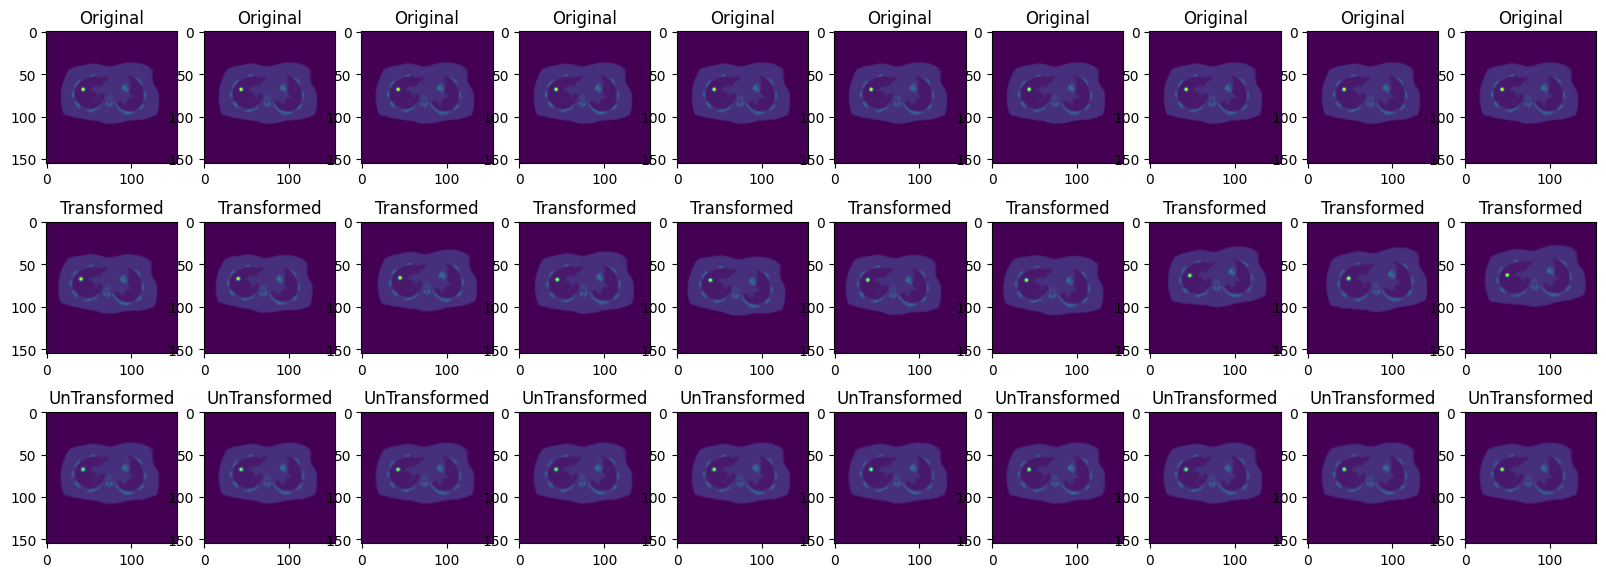

In [27]:
# OK and let's plot the original, transformed and "untransformed" images to see if they look sensible
fig, ax  = plt.subplots(3, num_motion_states, figsize=(20, 7))
for i in range(num_motion_states):
    ax[0, i].imshow(emission_image.as_array()[0, :, :])
    ax[0, i].set_title('Original')
    ax[1, i].imshow(motion_emissions[i].as_array()[0, :, :])
    ax[1, i].set_title('Transformed')
    ax[2, i].imshow(untransformed_images[i].as_array()[0, :, :])
    ax[2, i].set_title('UnTransformed')

In [28]:
# Right, now let's generate some acquisition models with the attenuation images from the motion states
acquisition_models = [get_acquisition_model(emission_image, template_sinogram, attn, num_subsets=1) for attn in motion_attenuations]

# And some simulated data using these acquisition models
acquired_data = [get_acquired_data(image, acq_model, noise_factor=0.01) for image, acq_model in zip(motion_emissions, acquisition_models)]

# acnd finally some sensitivity images for reconstruction
# This is the step that your project will aim to replace with a neural network
# It's not slow now because we're only using 2D images, but it will be slow when we move to 3D
sensitvity_images = [acq_model.backward(acquired_data[i].get_uniform_copy(1)) for i, acq_model in enumerate(acquisition_models)]


INFO: Processing view 3 of segment 0

INFO: Processing view 6 of segment 0

INFO: Processing view 2 of segment 0

INFO: Processing view 10 of segment 0

INFO: Processing view 1 of segment 0

INFO: Processing view 7 of segment 0

INFO: Processing view 4 of segment 0

INFO: Processing view 8 of segment 0

INFO: Processing view 11 of segment 0

INFO: Processing view 5 of segment 0

INFO: Processing view 9 of segment 0

INFO: Processing view 0 of segment 0

INFO: Processing view 12 of segment 0

INFO: Processing view 13 of segment 0

INFO: Processing view 14 of segment 0

INFO: Processing view 15 of segment 0

INFO: Processing view 16 of segment 0

INFO: Processing view 17 of segment 0

INFO: Processing view 18 of segment 0

INFO: Processing view 19 of segment 0

INFO: Processing view 20 of segment 0

INFO: Processing view 21 of segment 0

INFO: Processing view 22 of segment 0

INFO: Processing view 23 of segment 0

INFO: Processing view 24 of segment 0

INFO: Processing view 25 of segmen

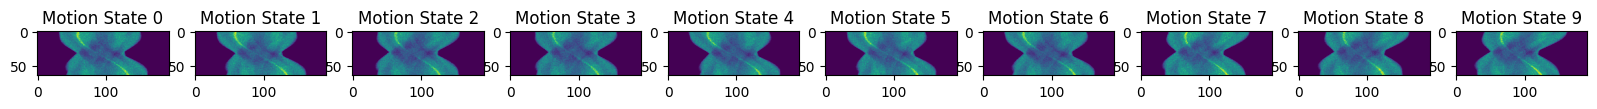

In [29]:
# let's see what the data looks like for each motion state
fig, ax  = plt.subplots(1, num_motion_states, figsize=(20, 4))
for i in range(num_motion_states):
    ax[i].imshow(acquired_data[i].as_array()[0, 0])
    ax[i].set_title('Motion State {}'.format(i))

Now let's compare the difference to the reconstructed image when we correct for motion and when we don't \
\
We'll start by setting up the reconstruction

In [30]:
# Setting up and inital image for reconstruction

initial_image = emission_image.get_uniform_copy(1)
cyl = stir.TruncateToCylinderProcessor()
cyl.set_strictly_less_than_radius(True)
cyl.apply(initial_image)

In [31]:
# this is the purely geometrical part of the forward projection

radon = stir.AcquisitionModelUsingRayTracingMatrix()
radon.num_subsets = 1
radon.set_up(template_sinogram, emission_image)

The normal formulation for MLEM, a widely used algorithm for image reconstruction is
$$ u^{(n+1)} = \frac{1}{s}A^\top\frac{f}{A u^{(n)}+ \eta} $$
where $u^{(n)}$ is our current image estimate, $f$ is our measured data, $A$ and $s$ ($=A^\top \mathbf{1}$) is our sensitivity image. \
\
If we now want to extend this to multiple motion states, we can use a subset version of the MLEM algorithm, known as OSEM where each subset of data $f_i$ is the data associated with motion state $i$. This motion subset also has an associated attenuation map, $u_i$, and an associated transform from out non-motion state, $T_i$
Our forward model can be broken down into a number of components
$$A_i = U(\mu_i) G T_i$$ 
where $U(\mu_i)$ contains the effect of attenuation on detection efficiencies and G contains the geometrical (radon) transform and detector efficiencies related to gaps in between crystals and detection efficiencies of the detectors themselves, \
\
Our Algorithm then becomes
$$ u^{(n+1)} = \frac{1}{s_i}A_i^\top\frac{f}{U(\mu_i) G T_i u^{(n)}+ \eta} $$
which can be rewritten as 
$$ u^{(n+1)} = \frac{1}{T_i^\top G^\top U(\mu_i)^\top \mathbf{1}}T_i^\top G^\top U(\mu_i)^\top\frac{f}{U(\mu_i) G T_i u^{(n)}+ \eta} $$
and can be simplified to
$$ u^{(n+1)} = \frac{1}{T_i^\top G^\top U(\mu_i)^\top \mathbf{1}}T_i^\top G^\top \frac{f}{G T_i u^{(n)}+ \eta} $$
as $U(\mu_i)$ is a diagonal matrix \
\
So, we have our algorithm. We transform our current image estimate to the motion state, forward project it, take the ratio with the motion state data, back project and transform back to the motionless state, and then divide by the sensitivity image in the motion state.\
\
This here is why we need to calculate the sensitivity image for every motion state. All these backprojections can be computationally intensive and se we are looking for a way to speed this up - but that's for another notebook

In [32]:
# osen reconstruction with motion correction
osem_recon = osem_reconstruction(initial_image, radon, acquired_data, num_subsets=num_motion_states, num_epochs=10, sensitivity_images=sensitvity_images, transform_matrices=motion_transforms)


INFO: Processing view 0 of segment 0

INFO: Processing view 2 of segment 0

INFO: Processing view 1 of segment 0

INFO: Processing view 3 of segment 0

INFO: Processing view 5 of segment 0

INFO: Processing view 4 of segment 0

INFO: Processing view 6 of segment 0

INFO: Processing view 7 of segment 0

INFO: Processing view 9 of segment 0

INFO: Processing view 8 of segment 0

INFO: Processing view 11 of segment 0

INFO: Processing view 10 of segment 0

INFO: Processing view 12 of segment 0

INFO: Processing view 13 of segment 0

INFO: Processing view 14 of segment 0

INFO: Processing view 15 of segment 0

INFO: Processing view 16 of segment 0

INFO: Processing view 17 of segment 0

INFO: Processing view 18 of segment 0

INFO: Processing view 19 of segment 0

INFO: Processing view 20 of segment 0

INFO: Processing view 21 of segment 0

INFO: Processing view 22 of segment 0

INFO: Processing view 23 of segment 0

INFO: Processing view 24 of segment 0

INFO: Processing view 25 of segmen

In [33]:
# osem reconstruction without motion correction
osem_recon_no_correction = osem_reconstruction(initial_image, radon, acquired_data, num_subsets=num_motion_states, num_epochs=10, sensitivity_images=sensitvity_images, resample=False)


INFO: Processing view 0 of segment 0

INFO: Processing view 1 of segment 0

INFO: Processing view 2 of segment 0

INFO: Processing view 3 of segment 0

INFO: Processing view 5 of segment 0

INFO: Processing view 4 of segment 0

INFO: Processing view 7 of segment 0

INFO: Processing view 8 of segment 0

INFO: Processing view 6 of segment 0

INFO: Processing view 10 of segment 0

INFO: Processing view 9 of segment 0

INFO: Processing view 11 of segment 0

INFO: Processing view 12 of segment 0

INFO: Processing view 13 of segment 0

INFO: Processing view 14 of segment 0

INFO: Processing view 15 of segment 0

INFO: Processing view 16 of segment 0

INFO: Processing view 17 of segment 0

INFO: Processing view 18 of segment 0

INFO: Processing view 19 of segment 0

INFO: Processing view 20 of segment 0

INFO: Processing view 21 of segment 0

INFO: Processing view 22 of segment 0

INFO: Processing view 23 of segment 0

INFO: Processing view 24 of segment 0

INFO: Processing view 25 of segmen

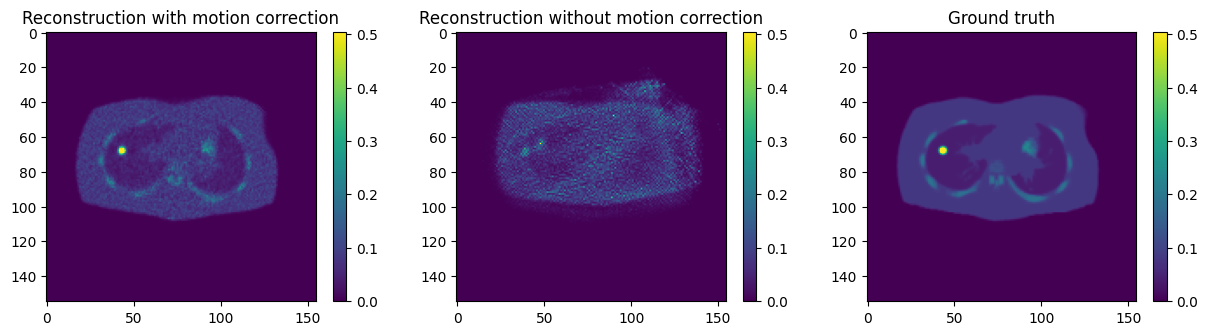

In [36]:
# Let's plot the results
max = min([osem_recon.max(), osem_recon_no_correction.max(), emission_image.max()])
fig, ax = plt.subplots(1, 3, figsize=(15, 3.5))
im0 = ax[0].imshow(osem_recon.as_array()[0, :, :], vmax=max)
ax[0].set_title('Reconstruction with motion correction')
im1 = ax[1].imshow(osem_recon_no_correction.as_array()[0, :, :], vmax=max)
ax[1].set_title('Reconstruction without motion correction')
im2 = ax[2].imshow(emission_image.as_array()[0, :, :], vmax=max)
ax[2].set_title('Ground truth')

plt.colorbar(im0, ax=ax[0])
plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])